```
# Code: systolic USP for action 2
# Author: Naveen Gangadharan, 2020
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from numpy import math
import statistics 
from numpy import NaN, Inf, arange, isscalar, asarray, array
import scipy
import pandas as pd
import csv
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import numpy as np
from scipy.signal import butter, filtfilt
from math import pi, log
from scipy import fft, ifft
from scipy.optimize import curve_fit
from scipy.signal import butter, lfilter, freqz, iirnotch
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import os
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import interpolate
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pi', 'log', 'ifft', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:

def butter_highpass_filter(data, cutoff, fs, order=5):
  nyq = 0.5 * fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='high', analog=False)
  y = filtfilt(b, a, data)
  return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


In [4]:
def peak_detect(x):
  inx, _ = find_peaks(x, prominence=0.000000001, distance=230)
  prominences = peak_prominences(x, inx)[0]
  peaks = [prominences[np.where(inx==i)] if i in inx else 0 for i in range(len(x))]
  return peaks

In [5]:
# def peak_and_valley_detect(x, prominence=0.0025, distance=230, width= [100,300]):
#   inx, _ = find_peaks(x, prominence=prominence, distance=distance, width=width)
#   prominences = peak_prominences(x, inx)[0]
#   widths = peak_widths (x,inx)[0]

#   # widths= [widths[np.where(inx==i)][0] if i in inx else 0 for i in range(len(x))]
#   peaks = [prominences[np.where(inx==i)][0] if i in inx else 0 for i in range(len(x))]
#   inx, _ = find_peaks(-x, prominence=prominence, distance=distance)
#   prominences = peak_prominences(-x, inx)[0]
#   valleys = [-prominences[np.where(inx==i)][0] if i in inx else 0 for i in range(len(x))]
#   return np.array(peaks)+np.array(valleys), widths


In [6]:
def peak_and_valley_detect(x, prominence=0.0005, distance=230, width= [10,700]): 
  # 0.0025 ori
  inx, _ = find_peaks(x, prominence=prominence, distance=distance)
  prominences = peak_prominences(x, inx, wlen=500)[0]
  widths = peak_widths (x,inx)[0]
  peaks = [prominences[np.where(inx==i)][0] if i in inx else 0 for i in range(len(x))]
  # widths= [widths[np.where(inx==i)][0] if i in inx else 0 for i in range(len(x))]
  
  inx1, _ = find_peaks(-x, prominence=prominence, distance=distance)
  prominences = peak_prominences(-x, inx1, wlen=500)[0]
  valleys = [-prominences[np.where(inx1==i)][0] if i in inx1 else 0 for i in range(len(x))]
  return np.array(peaks)+np.array(valleys), widths, inx, inx1

In [7]:
def sigmoid_5pl(x, a, b, c,d, e):
  return d + ((a-d)/(1+(x/c)**b)**e)

def sigmoid_4pl(x, a, b, c,d):
  return d + ((a-d)/1+(x/c)**b)

In [8]:
def save_df(df=None, filename=''):
    df.to_csv(filename, index=True)
    !cp -r $filename "/content/drive/My Drive/sphygmo/sphygmo/"

In [9]:
class NIBPProcessor(object):
  def __init__(self, filepath=''):
    time, ch1, ch2, ch3= np.loadtxt(filepath, dtype=('f4, f4, f4, f4'),unpack=True,delimiter = '\t')
    ip = pd.DataFrame()
    ch2=scipy.signal.medfilt(ch2,1)
    ch3=scipy.signal.medfilt(ch3,1)
    ip['time'] = time
    ip['ref_ppg'] = ch2 + 4
    ip['occ_ppg'] = ch3 + 4
    ip['pressure'] = ch1
    self.ip = ip
    self.op=0

  
  
  def save_peak_locations(self):
    self.ip['ref_peaks'],ref_wid, inxref,inx1ref = peak_and_valley_detect(self.ip['ref_ppg'],width=[10,300])
    self.ip['occ_peaks'],occ_wid, inxocc, inx1occ = peak_and_valley_detect(self.ip['occ_ppg'], prominence=0.0003,distance=230, width=[300,500])

    self.ip['std']= self.ip['occ_ppg'].rolling(2000).std()
    self.ip['stdr']= self.ip['ref_ppg'].rolling(2000).std()
    self.ip['occ1d'] = np.gradient(self.ip['occ_ppg'].values)
    self.ip['occ1d_peaks'] = peak_detect(self.ip['occ1d'])
    self.ip['ref1d'] = np.gradient(self.ip['ref_ppg'].values)
    self.ip['ref1d_peaks'] = peak_detect(self.ip['ref1d'])

  def detect_plateaus(self):
    plateau_width = 3000
    # Making a list of plateaus
    hts = np.linspace(0.0001, 1, 100)
    peaks, _ = find_peaks(self.ip['pressure'], width=plateau_width)

    plateaus = []
    for peak in peaks:
      for ht in hts:
        width, height, left, right = peak_widths(self.ip['pressure'], np.array([peak]), rel_height=ht)
        if width > plateau_width:
          break
      plateaus.append(self.ip.loc[left[0]:right[0]])
    # Finding mean pressure for each plateau
    mean_pressures = []
    mean_occppg=[]
    mean_refppg=[]
    for plateau in plateaus:
      plateau.drop(plateau.head(300).index, inplace=True) 
      plateau.drop(plateau.tail(900).index, inplace=True)
      mean_pressures.extend([plateau['pressure'].mean()] * len(plateau))
      mean_occppg.extend([plateau[plateau['occ_peaks']>0]['occ_peaks'].median()] * len(plateau))
      mean_refppg.extend([plateau[plateau['ref_peaks']>0]['ref_peaks'].median()] * len(plateau))




    self.ip = pd.concat(plateaus)
    self.ip['mean_pressure'] = mean_pressures
    self.ip['mean_occppg'] = mean_occppg
    self.ip['mean_refppg'] = mean_refppg
    self.ip = self.ip[np.invert(self.ip.index.duplicated())]

    
    for i,plateau in self.ip.groupby('mean_pressure'):
      fig, ax = plt.subplots()
      f1 = fig.add_subplot(2,1,1)
      f1.set_title('ref ppg at '+str(int(i))+'mmHg')
      f1.plot(plateau['ref_ppg'])
      f1.plot(1*plateau['ref_peaks']+plateau['ref_ppg'].mean(), 'r')


      f2 = fig.add_subplot(2,1,2)
      f2.set_title('occ ppg at '+str(int(i))+'mmHg')
      f2.plot(plateau['occ_ppg'])
      f2.plot(1*plateau['occ_peaks']+plateau['occ_ppg'].mean(), 'r')
      fig.tight_layout()

    return plateaus
  
  def separate_into_cycles(self, ppg='ref', separate_by_peak=True):
    detected_plateaus = self.ip['mean_pressure'].reindex(self.ip.index, fill_value=0).values

    # Making a list of occ ppg cycles
    cycles = []
    peaks = (self.ip[self.ip[f'{ppg}_peaks'] > 0].index).tolist()
    valleys = (self.ip[self.ip[f'{ppg}_peaks'] < 0].index).tolist()

    separator = peaks if separate_by_peak else valleys
    not_separator = valleys if separate_by_peak else peaks
    for i in range(1, len(separator)):
      cycles.append(self.ip.loc[separator[i - 1]:separator[i]])
    # to check if there are cycles with no valleys in between in ref arm, such cycles are ignored.
    cycles = [cycle for cycle in cycles if len(not_separator) != 0]
    begin = self.ip.loc[:separator[0]]
    return cycles


  def compute_ita(self):
    ita=[]
    cycle_pressure=[]
    cycles = self.separate_into_cycles(ppg='occ')
    for i,cycle in enumerate(cycles):
      if (cycle ['mean_pressure'].values[0] == cycle['mean_pressure'].values).all():
        tt1=cycle[cycle['occ_peaks']>0]['time'].values[0]
        pp1=cycle[cycle['occ_peaks']>0]['occ_peaks'].values[0]

        tt2=cycle[cycle['occ_peaks']<0]['time'].values[0]
        pp2=cycle[cycle['occ_peaks']<0]['occ_peaks'].values[0]

        tt3=cycle[cycle['occ_peaks']>0]['time'].values[-1]
        pp3=cycle[cycle['occ_peaks']>0]['occ_peaks'].values[-1]

        cycle_pressure.append(cycle['mean_pressure'].values[0])

        tt4=tt2-tt1
        tt5=tt3-tt2
        ita_cycle=(0.5*( (pp1*tt5) + (pp3*tt4)))
        ita.append(ita_cycle)

    itapd = pd.DataFrame()
    itapd['ita']=ita
    itapd['pressure']=cycle_pressure
    threshold = itapd['ita'].max()/30

    if len(itapd[itapd['ita']<threshold])!=0:
      first_zero = itapd[itapd['ita']<threshold]['pressure'].min()
    else:
      first_zero = itapd[itapd['ita']==(itapd['ita'].min())]['pressure'].min()
    return itapd, first_zero

  def fit_sigmoid(self, data, x, y):
    (a, b, c, d, e), _ = curve_fit(sigmoid_5pl, data[x], data[y], maxfev=5000)
    
    data['fit'] = sigmoid_5pl(data[x], a, b, c, d, e)
    # save_df(self.op, '_profile_pd.csv')

    fit = pd.DataFrame()
    fit['x'] = list(range(int(data[x].min()), int(data[x].max())))
    fit['y'] = np.interp(fit['x'], data[x], data['fit'])
    order = (fit['x'].max() - fit['x'].min()) / 10
    fit['d1'] = np.gradient(gaussian_filter1d(fit['y'], order))
    fit['d2'] = np.gradient(fit['d1'])
    return fit

  def fitting(self,input_file=''):
    amplitude = []
    cycle_pressure = []
    plateau_pressure = []
    ref_amplitude = []

    stdev = []
    auc = []
    occ1d = []
    delay = []
    ref_auc = []
    vol = []
    ref_vol = []
    full_auc = []
    corr=[]
    pre=0
    cycles = self.separate_into_cycles(ppg='ref', separate_by_peak=False)
    
    for i in range(len(cycles)):
      if (cycles[i]['mean_pressure'].values[0] == cycles[i]['mean_pressure'].values).all():
        stdev.append(cycles[i]['std'].values[0])
        c,v=scipy.stats.pearsonr(cycles[i]['ref_ppg'], cycles[i]['occ_ppg'])
        corr.append (c )
        # try:
        #   ref_amplitude.append(
        #       cycles[i][(cycles[i]['ref_peaks'] >0)]['ref_peaks'].values[0])
        # except:
        #   print(cycles[i]['ref_peaks'])


        try:
          print("pre try")
          past_ref=cycles[i][(cycles[i]['ref_peaks'] >0)]['ref_peaks'].values[0]
          ref_amplitude.append(cles[i][(cycles[i]['ref_peaks'] >0)]['ref_peaks'].values[0])
          print("post try")
        except:
          print("pre ex")
          ref_amplitude.append(past_ref)
          print("pst ex")
          print(cycles[i]['ref_peaks'])
          print(len(ref_amplitude))
          print("post excp")
          
        plateau_pressure.append(cycles[i]['mean_pressure'].values[0])
        cycle_pressure.append(cycles[i]['pressure'].mean())
        max = cycles[i]['occ_ppg'].values.max()
        maxref = cycles[i]['ref_ppg'].values.max()
        min = cycles[i]['occ_ppg'].values.min()
        minref = cycles[i]['ref_ppg'].values.min()
        delay_samples = abs(cycles[i][cycles[i]['ref_ppg']==maxref].index[0] - cycles[i][cycles[i]['occ_ppg']==max].index[0])
        # dich_inx = cycles[i][cycles[i]['ref1d_peaks']>0].index[-1]+delay_samples
        ref_inx = np.sort(np.array([cycles[i][cycles[i]['ref_ppg']==maxref].index[0],cycles[i][cycles[i]['ref_ppg']==minref].index[0]]))
        occ_inx = np.sort(np.array([cycles[i][cycles[i]['occ_ppg']==max].index[0],cycles[i][cycles[i]['occ_ppg']==min].index[0]]))
        # amplitude.append(max - cycles[i]['occ_ppg'].min())
        delay.append(delay_samples)
        occ1d.append(cycles[i]['occ1d'].max())
        auc.append((cycles[i].loc[:cycles[i][cycles[i]['occ_ppg']==max].index[0]]['occ_ppg'].values - cycles[i]['occ_ppg'].min()).sum())
        full_auc.append((cycles[i]['occ_ppg'].values - cycles[i]['occ_ppg'].min()).sum())
        ref_auc.append((cycles[i].loc[:cycles[i][cycles[i]['ref_ppg']==maxref].index[0]]['ref_ppg'].values - cycles[i]['ref_ppg'].min()).sum())
        vol.append((cycles[i].loc[occ_inx[0]:occ_inx[1]]['occ_ppg'].values - min).sum())
        ref_vol.append((cycles[i].loc[ref_inx[0]:ref_inx[1]]['ref_ppg'].values - minref).sum())
        if len(cycles[i][(cycles[i]['occ_peaks'] >0)]) != 0:
          amplitude.append(
            cycles[i][(cycles[i]['occ_peaks'] >0)]['occ_peaks'].values[0])
        else:
          amplitude.append(0)
          if(cycles[i]['mean_pressure'].values[0]!=0):
            pre= (cycles[i]['mean_pressure'].values[0])
        
        # plateau.drop(plateau.tail(750).index, inplace=True)
 
    # Putting the output variables in anot
    op = pd.DataFrame()
    op['plateau_pressure'] = plateau_pressure
    op['amplitude'] = amplitude
    op['cycle_pressure'] = cycle_pressure
    op['ref_amplitude'] = ref_amplitude
    op['ratio'] = np.divide(np.array(amplitude), np.array(ref_amplitude))


    op['stdev'] = stdev
    op['auc'] = auc
    op['occ1d'] = occ1d
    op['delay'] = delay
    op['ref_auc'] = ref_auc
    op['vol'] = vol
    op['ref_vol'] = ref_vol
    op['full_auc'] = full_auc
    op['occ_radius'] = np.sqrt(np.divide(op['auc'].values, np.ones(len(op))*np.pi))
    op['ref_radius'] = np.sqrt(np.divide(op['ref_auc'].values, np.ones(len(op))*np.pi))
    op['auc_ratio'] = np.divide(op['auc'].values, op['ref_auc'])
    op['corr']=corr

    # Removing outliers (helps fitting)
    op = op[(np.abs(stats.zscore(op)) < 3).all(axis=1)]
    op = op.sort_values('plateau_pressure')
    self.op=op

    # threshold = np.max(op.groupby('plateau_pressure').median()['amplitude'].values/10)
    # threshold=0.0004, added below
    threshold=0.0004
    # threshold = np.max(op.groupby('plateau_pressure').median()['auc_ratio'].values/25)  -works with same result like ration in nibp2.txt

    # threshold = np.max(op.groupby('plateau_pressure').median()['ratio'].values/30)
    if len(op[op['amplitude']<threshold])!=0:
      first_zero = op[op['amplitude']<threshold]['plateau_pressure'].min()
    else:
      first_zero = op[op['amplitude']==(op['amplitude'].min())]['plateau_pressure'].min()
    # print(f'ratio threshlding: {first_zero}')
    op['thr_ratio'] = op['amplitude'].values
    op['thr_ratio2'] = op['ref_amplitude'].values
    op['thr_ratio3'] = op['amplitude'].values
    op.loc[op['thr_ratio3']<threshold, 'thr_ratio3'] = 0
    op.loc[op['thr_ratio']<threshold, 'thr_ratio'] = 0
    # below line was not there added
    op.loc[op['thr_ratio2']<threshold, 'thr_ratio2'] = 0
    # print(op.groupby('plateau_pressure')['thr_ratio3'].apply(lambda x: x[x == 0].count()))
    # print(op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count()))
    # print(threshold)

    # below is for action2 , also change the thrshold to 25

    second_value=0
    first_non_zero=0
    third_value=0
    up_sys=0
    low_sys=0
    low_dias=0
    up_dias=0
    low_sys1=0
    zeros=nibp.op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count())
    zeros2=nibp.op.groupby('plateau_pressure')['thr_ratio2'].apply(lambda x: x[x != 0].count())
    zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})
    zerodf2 = pd.DataFrame(zeros2).rename(columns={'thr_ratio2':'zeros2'})
    zerodf = zerodf.reset_index()
    zerodf2 = zerodf2.reset_index()
    # print (zerodf['plateau_pressure'],np.divide(zerodf['zeros'].values, zerodf2['zeros2']))
    zerodf['zratio']= np.divide(zerodf['zeros'].values, zerodf2['zeros2'])
    print(zerodf)

    try:
      # t_pres= zerodf[zerodf['zratio']<=0.75]['plateau_pressure'].values.max() 
      t_pres= zerodf[zerodf['zratio']<=0.6]['plateau_pressure'].values.max() 
      # t_pres= zerodf[zerodf['zratio']<=0.6 and zerodf['zratio']>0.4]['plateau_pressure'].values.max() 
      print("prekkkkkk")
      # first_non_zero = np.max(zerodf[ (zerodf['zratio']>= 0.75) ]['plateau_pressure'].values)
      first_non_zero = (zerodf[(zerodf['plateau_pressure']> t_pres) & (zerodf['zratio']>= 0.85) ]['plateau_pressure'].values[0])
      # first_non_zero = np.max(zerodf[(zerodf['plateau_pressure']> t_pres) & (zerodf['zratio']>= 0.75) ]['plateau_pressure'].values)
      print("poatkkkk")

      # first_non_zero = zerodf[(zerodf['plateau_pressure']> t_pres) & (zerodf['zratio']>= 0.8) ]['plateau_pressure'].values[0] 
     

    #   second_value= zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['zeros'].values[0]
    #   third_value=zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +2]['zeros'].values[0]
    except:
      print("exxxxxxxxxxx")
      first_non_zero = zerodf[zerodf['zratio']>=0.83]['plateau_pressure'].values[0] if len(zerodf[zerodf['zratio']>=0.83]) > 0 else zerodf[zerodf['zratio']==zerodf['zratio'].max() ]['plateau_pressure'].values[0]
      # first_non_zero = zerodf[zerodf['zratio']>=0.83]['plateau_pressure'].values[0] if len(zerodf[zerodf['zratio']>=0.83]) > 0 else zerodf[zerodf['zratio']==zerodf['zratio'].max() ]['plateau_pressure'].values[0]

    
    # try:
    #   t_pres= zerodf[zerodf['zratio']< 0.83]['plateau_pressure'].values.max() 

    #   first_non_zero = zerodf[(zerodf['zratio']>= 0.83) and (zerodf['plateau_pressure']> t_pres)]['plateau_pressure'].values[0] 

    # #   second_value= zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['zeros'].values[0]
    # #   third_value=zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +2]['zeros'].values[0]
    # except:
    #   first_non_zero = zerodf[(zerodf['zratio']>= 0.83) or (zerodf['zratio']== zerodf['zratio'].max())]['plateau_pressure'].values[0] 

    #   second_value=0
    #   third_value=0
    # print(third_value)
    # # first_non_zero = 1 if len(zerodf[zerodf['zeros']==1]['zeros'])!=0 else zerodf[zerodf['zeros']!=0]['zeros'].values[0]
    # if first_non_zero >= 5:
    #   up_sys = zerodf[zerodf['zeros']!=0]['plateau_pressure'].values[0]
    #   low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['plateau_pressure']==up_sys].index[0]-1]
    # else:
    #   # low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']==first_non_zero])>1 else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
    #   low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[1] if (first_non_zero==1 and second_value ==1) else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
    #   low_sys1=low_sys
    #   if(first_non_zero==1 and second_value ==0 ):
    #     low_sys = zerodf[zerodf['plateau_pressure']>low_sys]['plateau_pressure'].values[1] if (second_value ==0 and third_value==1 ) else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
    #   # up_sys = zerodf[zerodf['zeros']==zerodf['zeros'].max()]['plateau_pressure'].values[0]
    #   # up_sys=zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
    #   try:
    #     up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[1] if len(zerodf[zerodf['zeros']>=5])>1 else zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
    #   except:
    #     up_sys=low_sys
    #     if (low_sys>up_sys):
    #       low_sys= zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
    print(first_non_zero)
    # print(low_sys, up_sys)
    # print("hello")
    # print(pre)



# below is for action1 and chnage thresh to 30

    # zeros=nibp.op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count())
    # zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})
    # zerodf = zerodf.reset_index()
    # i=0
    # flag=0
    # first_non_zero = zerodf[zerodf['zeros']!=0]['zeros'].values[0] 
    # try:
    #   i=6
    #   second_value= zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['zeros'].values[0]
    # except:
    #   i=7
    #   second_value=-3

    # if second_value==0:
    #   flag=1
    #   i=3
    #   ls=zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['plateau_pressure'].values[0]
    #   first_non_zero=zerodf[zerodf['plateau_pressure']>ls][zerodf['zeros']!=0]['zeros'].values[0]
    #   fls=zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
    #   # ls=zerodf['plateau_pressure'].values[zerodf[zerodf['zeros']==first_non_zero].index[0]]
      
    #   if first_non_zero >= 5:
    #     print(1)
    #     up_sys = zerodf[zerodf['zeros'].values==zerodf[zerodf['plateau_pressure']>=fls]['zeros'].values[:2].max()]['plateau_pressure'].values[0]
    #     low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['plateau_pressure']==fls]['plateau_pressure'].index[0]-1]
    # # break

    # if first_non_zero >= 5 and flag==0 :

    #   i=2
    #   # up_sys = max(zerodf[zerodf['zeros']!=0]['plateau_pressure'].values[:2])
    #   # low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['plateau_pressure']==up_sys].index[0]-2]
    #   up_sys = zerodf[zerodf['zeros'].values==[zerodf[zerodf['zeros']!=0]['zeros'].values[:2].max()]]['plateau_pressure'].values[0]
      
    #   low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['zeros']==first_non_zero].index[0]-1]
    # elif first_non_zero < 5 and flag==0 :
    #   i=1
    #   # low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']==first_non_zero])>1 else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
    #   low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[1] if (first_non_zero==1 and second_value ==1) else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
      

    #   # up_sys = zerodf[zerodf['zeros']==zerodf['zeros'].max()]['plateau_pressure'].values[0]
    #   # up_sys=zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
    #   try:
    #     up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']>=5])>1 else zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()][zerodf['plateau_pressure']>low_sys]['plateau_pressure'].values[0]
    #     # if len(zerodf[zerodf['zeros']>=5])>1:
    #     #   if(zerodf[zerodf['zeros']>=5]['zeros'].values[0]==zerodf[zerodf['zeros']>=5]['zeros'].values[1]):
    #     #     up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[1]
    #   except:
    #     up_sys=low_sys
    #   if (low_sys>up_sys):
    #     low_sys= zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
      

    # # print(i)
    # print(low_sys, up_sys)
  



# old code without some checks, dont use this below section
    # second_value=0
    # first_non_zero=0
    # up_sys=0
    # low_sys=0
    # zeros=nibp.op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count())
    # zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})
    # zerodf = zerodf.reset_index()
    # first_non_zero = zerodf[zerodf['zeros']!=0]['zeros'].values[0] 
    # try:
    #   second_value= zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['zeros'].values[0]
    # except:
    #   second_value=0

    # # first_non_zero = 1 if len(zerodf[zerodf['zeros']==1]['zeros'])!=0 else zerodf[zerodf['zeros']!=0]['zeros'].values[0]
    # if first_non_zero >= 5:
    #   print(1)
    #   up_sys = zerodf[zerodf['zeros'].values==[zerodf[zerodf['zeros']!=0]['zeros'].values[:2].max()]]['plateau_pressure'].values[0]
      
    #   low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['zeros']==first_non_zero].index[0]-1]
    # else:
    #   # low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']==first_non_zero])>1 else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
    #   low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[1] if (first_non_zero==1 and second_value ==1) else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
    #   # up_sys = zerodf[zerodf['zeros']==zerodf['zeros'].max()]['plateau_pressure'].values[0]
    #   # up_sys=zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
    #   try:
    #     up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']>=5])>1 else zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
    #     # if len(zerodf[zerodf['zeros']>=5])>1:
    #     #   if(zerodf[zerodf['zeros']>=5]['zeros'].values[0]==zerodf[zerodf['zeros']>=5]['zeros'].values[1]):
    #     #     up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[1]
    #   except:
    #     up_sys=low_sys
    #   if (low_sys>up_sys):
    #     low_sys= zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
      


    # print(low_sys, up_sys)



    try:
      (a, b, c, d, e), _ = curve_fit(sigmoid_5pl, self.op['plateau_pressure'], self.op['ratio'], maxfev=5000)
    except:
      w = plt.scatter(self.op['plateau_pressure'], self.op['ratio'])
      plt.subplots_adjust(bottom=0.3)
      plt.gcf().text(0.05, 1.05, input_file.split('/')[-1].split('.')[0], fontsize=16)

      axes = plt.gca()
      num = (self.op['ratio'].max()-self.op['ratio'].min())/5
      axes.set_ylim([self.op['ratio'].min()-num, self.op['ratio'].max()+num])
      axes.set_xlim([0, 200])

      plt.xlabel('Pressures in mmHg');
      plt.ylabel('PPG');
      plt.title('Peak Detect: 5PL Sigmoid Fit Failed')
      plt.savefig(input_file[:-4]+'_pd.png')
      plt.tight_layout(h_pad=1)
      plt.show()
      return [np.nan, np.nan, np.nan, np.nan], [np.nan, np.nan, np.nan, np.nan]
  
    self.op['fit'] = sigmoid_5pl(self.op['plateau_pressure'], a, b, c, d, e)
    save_df(self.op, '_profile_pd.csv')

    fit = pd.DataFrame()
    fit['x'] = list(range(int(self.op['plateau_pressure'].min()), int(self.op['plateau_pressure'].max())))
    fit['y'] = np.interp(fit['x'], self.op['plateau_pressure'], self.op['fit'])
    order = (fit['x'].max() - fit['x'].min()) / 10
    fit['d1'] = np.gradient(gaussian_filter1d(fit['y'], order))
    fit['d2'] = np.gradient(fit['d1'])
    save_df(fit, '_slopes_pd.csv')

    temp = pd.DataFrame()
    temp['pressures'] = np.sort(list(set(op['plateau_pressure'])))
    temp['variances'] = [self.op[self.op['plateau_pressure'] == pressure]['ratio'].var() for pressure in temp['pressures']]
    temp['median'] = [self.op[self.op['plateau_pressure'] == pressure]['ratio'].median() for pressure in temp['pressures']]

    plt.figure(figsize=(7.5, 7.5))

    # Max and min of 2nd derivative
    up_dias = fit[fit['d2'] == fit['d2'].min()]['x'].values[0]
    low_sys = fit[fit['d2'] == fit['d2'].max()]['x'].values[0]

    # nearest cuff pressure value
    temp['up_dias_diff'] = abs(temp['pressures'].values-up_dias)
    temp['low_sys_diff'] = abs(temp['pressures'].values-low_sys)
    up_dias = int(temp[temp['up_dias_diff']==temp['up_dias_diff'].min()]['pressures'].values[0])
    low_sys = int(temp[temp['low_sys_diff']==temp['low_sys_diff'].min()]['pressures'].values[0])

    x = temp[temp['pressures'] < up_dias]
    try:
      # take last values with median below fit line before up_dias
      low_dias = int(x[x['median']<fit['y'].max()]['pressures'].values[-1])
    except:
      if len(x)==0:
        # there are no pressure values below up_dias
        low_dias = up_dias
      else:
        # in case of no median below fit, take the lowest point
        low_dias = int(x[x['median']==x['median'].min()]['pressures'].values[0])
    x = temp[(temp['pressures']- low_sys)>1]
    try:
      up_sys = int(x[x['variances'] == x['variances'].min()]['pressures'].values[0])
    except:
      # there are no values greater than low_sys
      up_sys = low_sys

    infls = [low_dias, up_dias, low_sys, up_sys]

    plt.subplot(2, 1, 1)
    w = plt.scatter(self.op['plateau_pressure'], self.op['ratio'])
    plt.plot(fit['x'], fit['y'])
    for i, inf in enumerate(infls, 1):
      plt.axvline(x=inf, color='k', label=f'Inflection Point {i}')

    textstr = 'systolic range: ' + str(low_sys) + ' - ' + str(up_sys) + ' mmHg\ndiastolic range: ' + str(
      low_dias) + ' - ' + str(up_dias) + ' mmHg'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gcf().text(0.6, 0.9, textstr, fontsize=10, bbox=props)

    axes = plt.gca()
    num = (self.op['ratio'].max()-self.op['ratio'].min())/5
    axes.set_ylim([self.op['ratio'].min()-num, self.op['ratio'].max()+num ])
    axes.set_xlim([0, 200])

    plt.xlabel('Pressures in mmHg');
    plt.ylabel('PPG');
    plt.title('Peak Detect Inflection Points')

    # Intersection of lines through max, min, infl of fit
    try:
      infl = [x for x in fit[np.sign(fit['d2']).diff() != 0]['x'].values if (x > up_dias) & (x < low_sys)][0]
    except:
      plt.subplot(2,1,2)
      w = plt.scatter(self.op['plateau_pressure'], self.op['ratio'])
      plt.subplots_adjust(bottom=0.3)
      plt.gcf().text(0.05, 1.05, input_file.split('/')[-1].split('.')[0], fontsize=16)

      axes = plt.gca()
      num = (self.op['ratio'].max()-self.op['ratio'].min())/5
      axes.set_ylim([self.op['ratio'].min()-num, self.op['ratio'].max()+num ])
      axes.set_xlim([0, 200])

      plt.xlabel('Pressures in mmHg');
      plt.ylabel('PPG');
      plt.title('Peak Detect: Intersection Failed')    
      plt.tight_layout(h_pad=1)
      plt.savefig(input_file[:-4]+'_pd.png')
      plt.show()
      return infls, [np.nan, np.nan, np.nan, np.nan]

    x1_high = fit['x'].min()
    y1_high = fit[fit['x'] == fit['x'].min()]['y'].values[0]
    # m_high = fit[fit['x'] == fit['x'].min()]['d1'].values[0]
    m_high= (fit[fit['x'] == fit['x'].min()+10]['y'].values[0] -y1_high)/10
    fit['line_high'] = (fit['x'] - x1_high) * m_high + y1_high

    # x1_infl = infl
    # y1_infl = fit[fit['x'] == infl]['y'].values[0]
    # m_infl = fit[fit['x'] == infl]['d1'].values[0]
    # fit['line_infl'] = (fit['x'] - x1_infl) * m_infl + y1_infl

    x1 = infl-5
    y1 = fit[fit['x'] == (infl-5)]['y'].values[0]
    # m = fit[fit['x'] == infl]['d1'].values[0]
    m=  (fit[fit['x'] == (infl+5)]['y'].values[0] - y1)/10
    # m= fit['d1'].min()
    # m = fit[fit.index==fit[fit['x']==infl].index[0]+10]['d1'].values[0]
    print(m)
    fit['line_infl'] = (fit['x'] - x1) * m + y1

    x1_low = fit['x'].max()
    y1_low = fit[fit['x'] == fit['x'].max()]['y'].values[0]
    m_low = fit[fit['x'] == fit['x'].max()]['d1'].values[0]
    fit['line_low'] = (fit['x'] - x1_low) * m_low + y1_low

    plt.subplot(2, 1, 2)
    w = plt.scatter(self.op['plateau_pressure'], self.op['ratio'])
    plt.plot(fit['x'], fit['y'])
    plt.plot(fit['x'], fit['line_high'], '--', linewidth=1.2)
    plt.plot(fit['x'], fit['line_infl'], '--', linewidth=1.2)
    plt.plot(fit['x'], fit['line_low'], '--', linewidth=1.2)

    plt.plot(infl, fit[fit['x'] == infl]['y'].values[0], 'ro')
    try:
      idx1 = np.argwhere(np.diff(np.sign(fit['line_high'] - fit['line_infl']))).flatten()[0]
    except:
      # there's no intersection
      idx1 = 0
    up_dias = fit['x'].values[idx1] 
    try:
      idx2 = np.argwhere(np.diff(np.sign(fit['line_infl'] - fit['line_low']))).flatten()[0]    
    except:
      # there's no intersection
      idx2 = -1
    low_sys = fit['x'].values[idx2]

    # take nearest cuff pressure value
    temp['up_dias_diff'] = abs(temp['pressures'].values-up_dias)
    temp['low_sys_diff'] = abs(temp['pressures'].values-low_sys)
    up_dias = int(temp[temp['up_dias_diff']==temp['up_dias_diff'].min()]['pressures'].values[0])
    low_sys = int(temp[temp['low_sys_diff']==temp['low_sys_diff'].min()]['pressures'].values[0])

    plt.plot(up_dias, fit['line_high'].values[idx1], 'ro')
    plt.plot(low_sys, fit['line_low'].values[idx2], 'ro')

    x = temp[temp['pressures'] < up_dias]
    try:
      # take last values with median below fit line before up_dias
      low_dias = int(x[x['median']<fit['y'].max()]['pressures'].values[-1])
    except:
      if len(x)==0:
        # there are no pressure values below up_dias
        low_dias = up_dias
      else:
        # in case of no median below fit, take the lowest point
        low_dias = int(x[x['median']==x['median'].min()]['pressures'].values[0])
    x = temp[(temp['pressures']-low_sys)>1]
    try:
      up_sys = int(x[x['variances'] == x['variances'].min()]['pressures'].values[0])
    except:
      # no values greater than low_sys
      up_sys = low_sys

    plt.plot(low_dias, fit[fit['x'] > low_dias]['y'].max(), 'ro')
    plt.plot(up_sys, fit[fit['x'] < up_sys]['y'].min(), 'ro')

    textstr = 'systolic range: ' + str(low_sys) + ' - ' + str(up_sys) + ' mmHg\ndiastolic range: ' + str(
      low_dias) + ' - ' + str(up_dias) + ' mmHg'
    plt.subplots_adjust(bottom=0.3)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gcf().text(0.6, 0.4, textstr, fontsize=10, bbox=props)
    plt.gcf().text(0.05, 1.05, input_file.split('/')[-1].split('.')[0], fontsize=16)

    axes = plt.gca()
    num = (self.op['ratio'].max()-self.op['ratio'].min())/5
    axes.set_ylim([self.op['ratio'].min()-num, self.op['ratio'].max()+num ])
    axes.set_xlim([0, 200])

    plt.xlabel('Pressures in mmHg');
    plt.ylabel('PPG');
    plt.title('Peak Detect Intersection Points')  
    plt.tight_layout(h_pad=1)
    plt.savefig(input_file[:-4]+'_pd.png')
    plt.show()
    inters = [low_dias, up_dias, low_sys, up_sys]

    return infls, inters

      

220413AP


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


pre try
pre ex
pst ex
6468   -0.011333
6469    0.000000
6470    0.000000
6471    0.000000
6472    0.000000
          ...   
6831    0.000000
6832    0.000000
6833    0.000000
6834    0.000000
6835   -0.013688
Name: ref_peaks, Length: 368, dtype: float64
1
post excp
pre try
pre ex
pst ex
6835   -0.013688
6836    0.000000
6837    0.000000
6838    0.000000
6839    0.000000
          ...   
7196    0.000000
7197    0.000000
7198    0.000000
7199    0.000000
7200   -0.014241
Name: ref_peaks, Length: 366, dtype: float64
2
post excp
pre try
pre ex
pst ex
7200   -0.014241
7201    0.000000
7202    0.000000
7203    0.000000
7204    0.000000
          ...   
7561    0.000000
7562    0.000000
7563    0.000000
7564    0.000000
7565   -0.015848
Name: ref_peaks, Length: 366, dtype: float64
3
post excp
pre try
pre ex
pst ex
7565   -0.015848
7566    0.000000
7567    0.000000
7568    0.000000
7569    0.000000
          ...   
7929    0.000000
7930    0.000000
7931    0.000000
7932    0.000000
7933   -0.

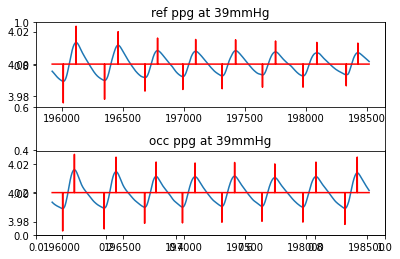

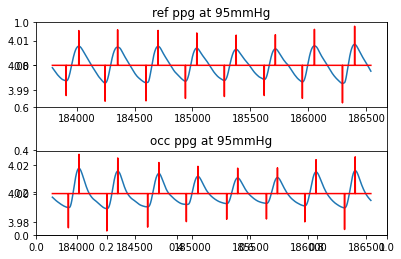

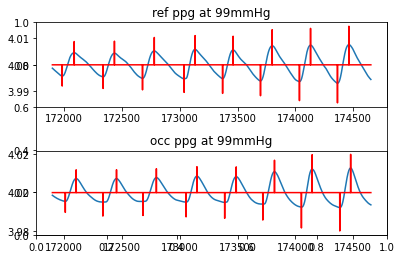

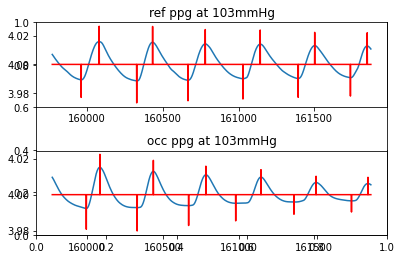

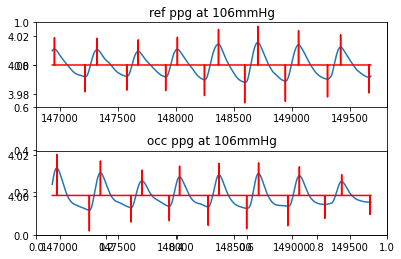

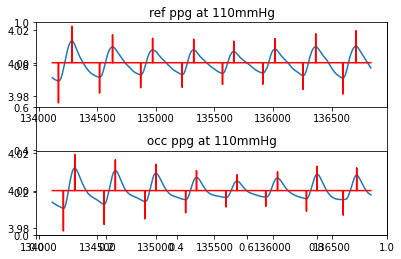

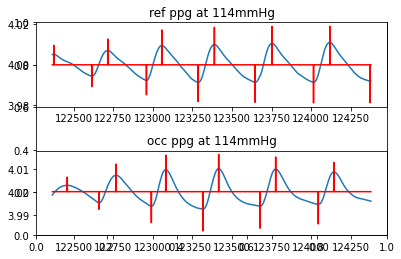

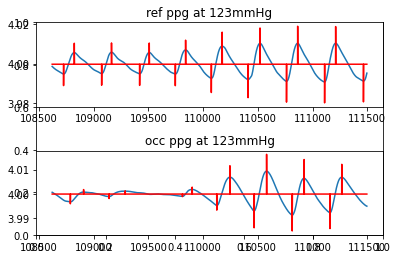

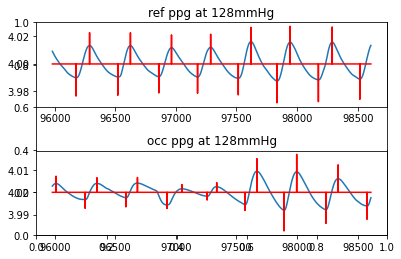

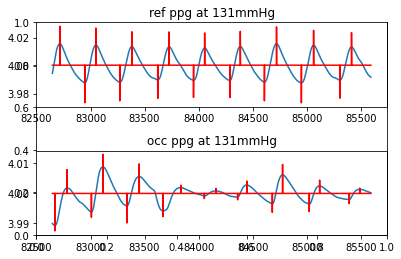

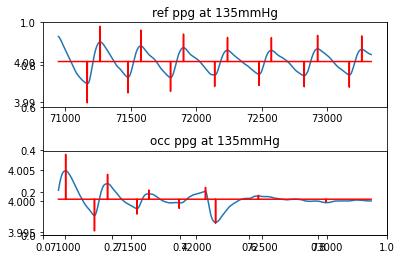

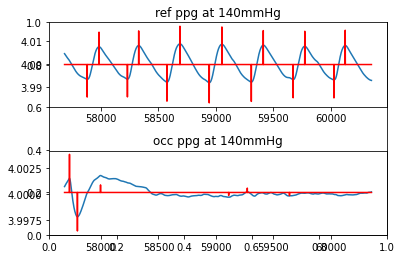

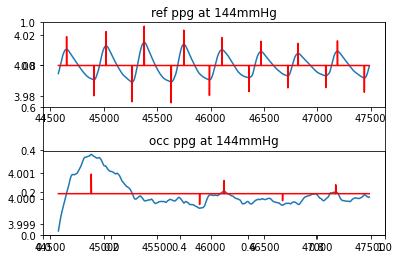

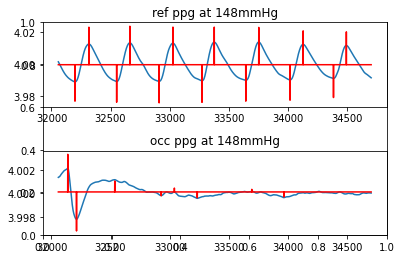

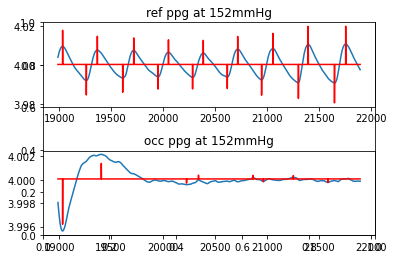

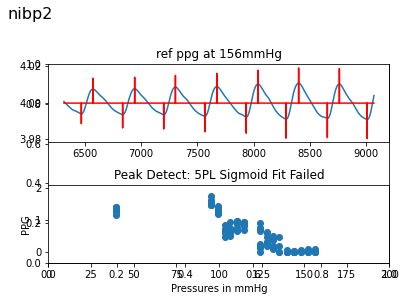

In [12]:
patients=[]
lsys=[]
infls_all=[]
inters_all=[]
folder = '/content/drive/MyDrive/sphygmo/sphygmo/from04/'
patients = ['220413AP']
# [x for x in os.listdir(folder)if x.find('P')!=-1]
# for patient in [x for x in os.listdir(folder)if x.find('P')!=-1]:
for patient in [x for x in patients]:
  print(f'{patient}')
  nibp = NIBPProcessor(folder+patient+'/nibp2.txt')
  nibp.save_peak_locations()
  nibp.detect_plateaus()

  infls, inters = nibp.fitting(folder+patient+'/nibp2.txt')
  infls_all.append(infls)
  inters_all.append(inters)
  # nibp.detect_plateaus()
  # ita1, sys1 = nibp.compute_ita()
  
  patients.append(patient)
  # break
  # lsys.append(sys1)
# exis = pd.read_csv(folder+'naveen1.csv')
all = pd.DataFrame()
# all['patient'] = patients
# all['infl_low_dias'] = infls_all[:, 0]
# all['infl_up_dias'] = infls_all[:, 1]
# all['infl_low_sys'] = infls_all[:, 2]
# all['infl_up_sys'] = infls_all[:, 3]
# all['inter_low_dias'] = inters_all[:, 0]
# all['inter_up_dias'] = inters_all[:, 1]
# all['inter_low_sys'] = inters_all[:, 2]
# all['inter_up_sys'] = inters_all[:, 3]
# all = pd.concat([all, exis])
save_df(all, folder+'naveen1.csv')
# rangedf = pd.DataFrame()  
# rangedf['patient']=patients
# rangedf['Low_sys']=lsys
  # save_df(nibp.ip)

210803BP


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


pre try
pre ex
pst ex
4670   -0.053288
4671    0.000000
4672    0.000000
4673    0.000000
4674    0.000000
          ...   
4920    0.000000
4921    0.000000
4922    0.000000
4923    0.000000
4924   -0.049684
Name: ref_peaks, Length: 255, dtype: float64
1
post excp
pre try
pre ex
pst ex
4924   -0.049684
4925    0.000000
4926    0.000000
4927    0.000000
4928    0.000000
          ...   
5213    0.000000
5214    0.000000
5215    0.000000
5216    0.000000
5217   -0.046097
Name: ref_peaks, Length: 294, dtype: float64
2
post excp
pre try
pre ex
pst ex
5217   -0.046097
5218    0.000000
5219    0.000000
5220    0.000000
5221    0.000000
          ...   
5467    0.000000
5468    0.000000
5469    0.000000
5470    0.000000
5471   -0.045981
Name: ref_peaks, Length: 255, dtype: float64
3
post excp
pre try
pre ex
pst ex
5471   -0.045981
5472    0.000000
5473    0.000000
5474    0.000000
5475    0.000000
          ...   
5751    0.000000
5752    0.000000
5753    0.000000
5754    0.000000
5755   -0.

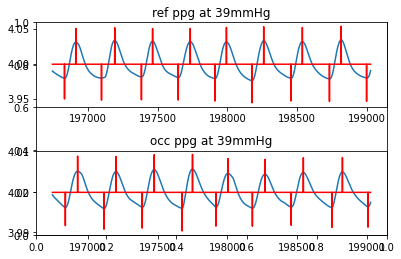

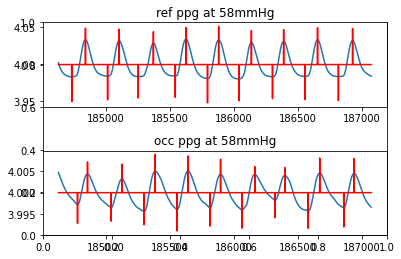

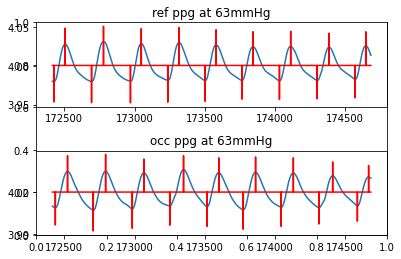

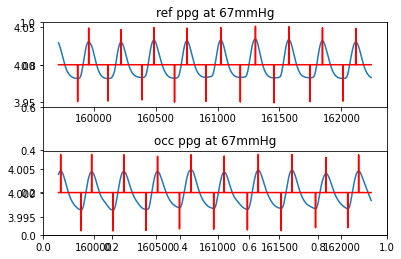

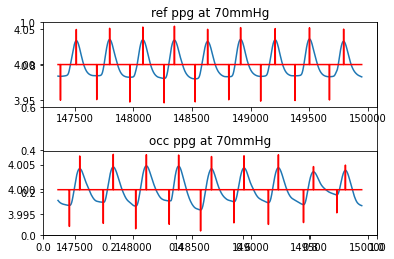

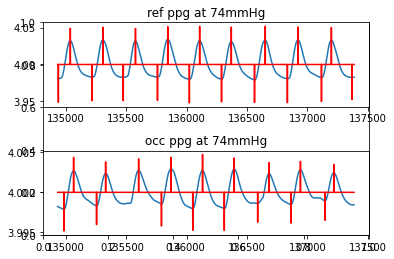

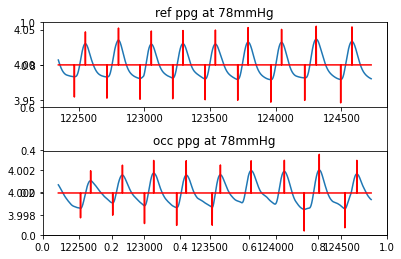

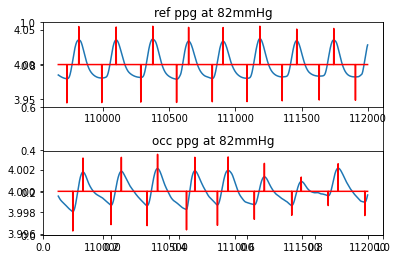

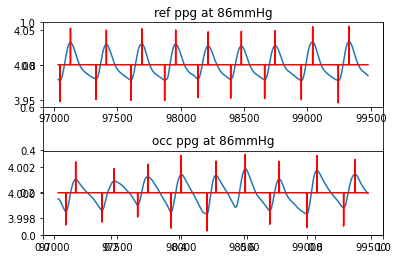

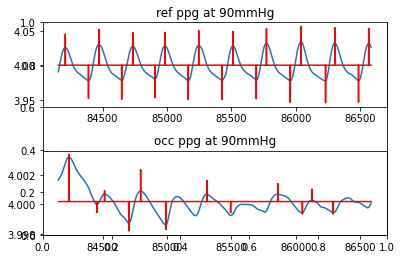

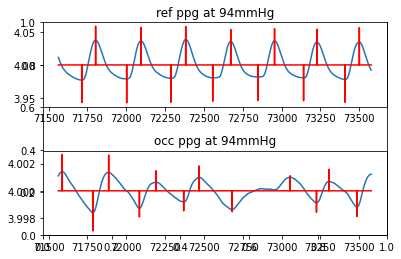

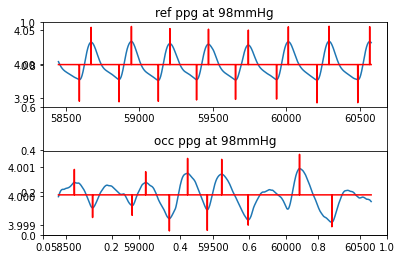

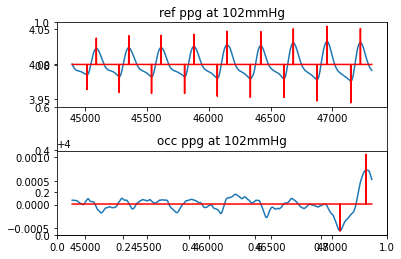

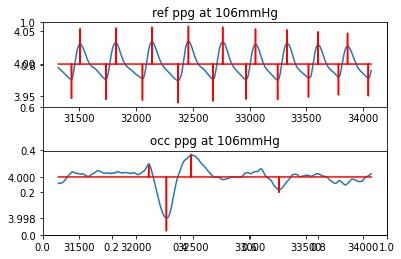

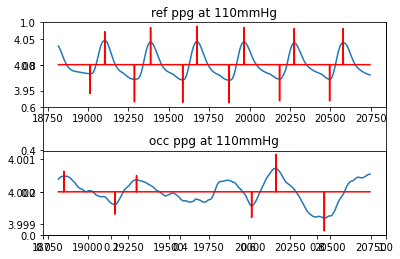

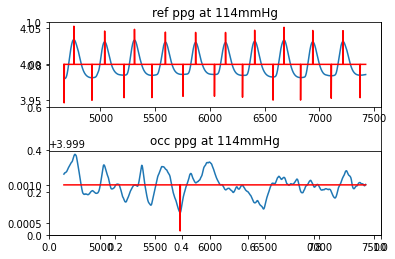

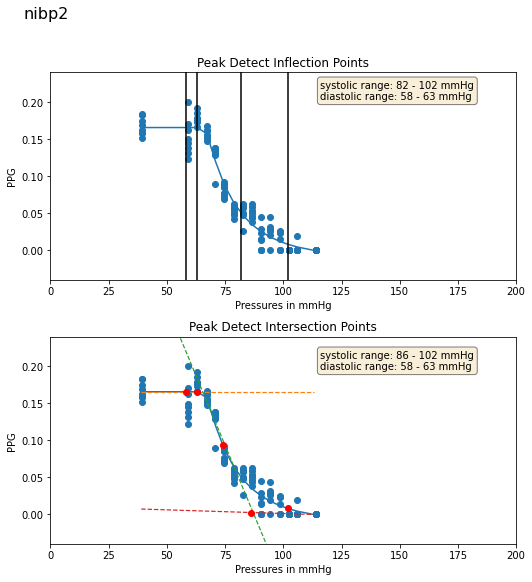

In [ ]:
patients=[]
lsys=[]
infls_all=[]
inters_all=[]
folder = '/content/drive/MyDrive/data40/sphygmo/'
patients = ['210803BP']
# [x for x in os.listdir(folder)if x.find('P')!=-1]
# for patient in [x for x in os.listdir(folder)if x.find('P')!=-1]:
for patient in [x for x in patients]:
  print(f'{patient}')
  nibp = NIBPProcessor(folder+patient+'/nibp2.txt')
  nibp.save_peak_locations()
  nibp.detect_plateaus()

  infls, inters = nibp.fitting(folder+patient+'/nibp2.txt')
  infls_all.append(infls)
  inters_all.append(inters)
  # nibp.detect_plateaus()
  # ita1, sys1 = nibp.compute_ita()
  
  patients.append(patient)
  # break
  # lsys.append(sys1)
# exis = pd.read_csv(folder+'naveen1.csv')
all = pd.DataFrame()
# all['patient'] = patients
# all['infl_low_dias'] = infls_all[:, 0]
# all['infl_up_dias'] = infls_all[:, 1]
# all['infl_low_sys'] = infls_all[:, 2]
# all['infl_up_sys'] = infls_all[:, 3]
# all['inter_low_dias'] = inters_all[:, 0]
# all['inter_up_dias'] = inters_all[:, 1]
# all['inter_low_sys'] = inters_all[:, 2]
# all['inter_up_sys'] = inters_all[:, 3]
# all = pd.concat([all, exis])
save_df(all, folder+'naveen1.csv')
# rangedf = pd.DataFrame()  
# rangedf['patient']=patients
# rangedf['Low_sys']=lsys
  # save_df(nibp.ip)

In [ ]:
pdf = PdfPages('debug15BP.pdf')
for i,plateau in nibp.op.groupby('mean_pressure'):
  fig, ax = plt.subplots()
  f1 = fig.add_subplot(2,1,1)
  f1.set_title('ref ppg at '+str(int(i))+'mmHg')
  f1.plot(plateau['ref_ppg'])
  f1.plot(0.5*plateau['ref_peaks']+plateau['ref_ppg'].mean(), 'r')


  f2 = fig.add_subplot(2,1,2)
  f2.set_title('occ ppg at '+str(int(i))+'mmHg')
  f2.plot(plateau['occ_ppg'])
  f2.plot(0.5*plateau['occ_peaks']+plateau['occ_ppg'].mean(), 'r')
  fig.tight_layout()
  pdf.savefig(fig)

pdf.close()
!cp -r 'debug15BP.pdf' "/content/drive/My Drive/n33/"

In [ ]:
nibp.op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count())
zeros=nibp.op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count())
zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})

In [ ]:
# zerodf=pd.DataFrame()
zerodf['zeros'] = np.append(np.zeros(11), np.array([6, 2, 3, 4, 4]))
# zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})
zerodf = zerodf.reset_index()
zerodf

In [ ]:
zerodf[zerodf['zeros'].values==[zerodf[zerodf['zeros']!=0]['zeros'].values[:2].max()]]['plateau_pressure'].values[0]

for ACTION 2


In [ ]:
# zeros=nibp.op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count())
zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})
zerodf = zerodf.reset_index()
first_non_zero = zerodf[zerodf['zeros']!=0]['zeros'].values[0] 
try:
  second_value= zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['zeros'].values[0]
except:
  second_value=0

# first_non_zero = 1 if len(zerodf[zerodf['zeros']==1]['zeros'])!=0 else zerodf[zerodf['zeros']!=0]['zeros'].values[0]
if first_non_zero >= 5:
  up_sys = zerodf[zerodf['zeros']!=0]['plateau_pressure'].values[0]
  low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['plateau_pressure']==up_sys].index[0]-1]
else:
  # low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']==first_non_zero])>1 else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
  low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[1] if (first_non_zero==1 and second_value ==1) else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
  # up_sys = zerodf[zerodf['zeros']==zerodf['zeros'].max()]['plateau_pressure'].values[0]
  # up_sys=zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
  try:
    up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']>=5])>1 else zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
  except:
    up_sys=low_sys
  if (low_sys>up_sys):
    low_sys= zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
  


print(low_sys, up_sys)

108.74514770507812 117.58656311035156


In [ ]:
# zerodf=pd.DataFrame()
zerodf['zeros'] = np.append(np.zeros(11), np.array([4, 2, 5, 0, 4]))
# zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})
# zerodf = zerodf.reset_index()
zerodf

,level_0,index,plateau_pressure,zeros
0,0,0,28.727533,0.0
1,1,1,34.796856,0.0
2,2,2,41.736168,0.0
3,3,3,48.513145,0.0
4,4,4,55.990128,0.0
5,5,5,62.701233,0.0
6,6,6,68.614914,0.0
7,7,7,75.534721,0.0
8,8,8,82.398605,0.0
9,9,9,89.257248,0.0


FOR ACTION 1


In [ ]:
# zeros=nibp.op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count())
# zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})
# zerodf = zerodf.reset_index()
i=0
flag=0
first_non_zero = zerodf[zerodf['zeros']!=0]['zeros'].values[0] 
try:
  i=6
  second_value= zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['zeros'].values[0]
except:
  i=7
  second_value=-3

if second_value==0:
  flag=1
  i=3
  ls=zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['plateau_pressure'].values[0]
  first_non_zero=zerodf[zerodf['plateau_pressure']>ls][zerodf['zeros']!=0]['zeros'].values[0]
  fls=zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
  # ls=zerodf['plateau_pressure'].values[zerodf[zerodf['zeros']==first_non_zero].index[0]]
  
  if first_non_zero >= 5:
    print(1)
    up_sys = zerodf[zerodf['zeros'].values==zerodf[zerodf['plateau_pressure']>=fls]['zeros'].values[:2].max()]['plateau_pressure'].values[0]
    low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['plateau_pressure']==fls]['plateau_pressure'].index[0]-1]
# break



# first_non_zero = 1 if len(zerodf[zerodf['zeros']==1]['zeros'])!=0 else zerodf[zerodf['zeros']!=0]['zeros'].values[0]
if first_non_zero >= 5 and flag==0 :

  i=2
  # up_sys = max(zerodf[zerodf['zeros']!=0]['plateau_pressure'].values[:2])
  # low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['plateau_pressure']==up_sys].index[0]-2]
  up_sys = zerodf[zerodf['zeros'].values==[zerodf[zerodf['zeros']!=0]['zeros'].values[:2].max()]]['plateau_pressure'].values[0]
  
  low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['zeros']==first_non_zero].index[0]-1]
elif first_non_zero < 5 and flag==0 :
  i=1
  # low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']==first_non_zero])>1 else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
  low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[1] if (first_non_zero==1 and second_value ==1) else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
  

  # up_sys = zerodf[zerodf['zeros']==zerodf['zeros'].max()]['plateau_pressure'].values[0]
  # up_sys=zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
  try:
    up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']>=5])>1 else zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()][zerodf['plateau_pressure']>low_sys]['plateau_pressure'].values[0]
    # if len(zerodf[zerodf['zeros']>=5])>1:
    #   if(zerodf[zerodf['zeros']>=5]['zeros'].values[0]==zerodf[zerodf['zeros']>=5]['zeros'].values[1]):
    #     up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[1]
  except:
    up_sys=low_sys
  if (low_sys>up_sys):
    low_sys= zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
  

# print(i)
print(low_sys, up_sys)

1
103.31936645507812 112.80358123779297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()][zerodf['plateau_pressure']>low_sys]['plateau_pressure'].values[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


132.47451782226562

ORIGINAL action 2, thresh 25

In [ ]:

    # below is for action2 

    second_value=0
    first_non_zero=0
    up_sys=0
    low_sys=0
    zeros=nibp.op.groupby('plateau_pressure')['thr_ratio'].apply(lambda x: x[x == 0].count())
    zerodf = pd.DataFrame(zeros).rename(columns={'thr_ratio':'zeros'})
    zerodf = zerodf.reset_index()
    first_non_zero = zerodf[zerodf['zeros']!=0]['zeros'].values[0] 
    try:
      second_value= zerodf[zerodf.index==zerodf[zerodf['zeros']==first_non_zero].index.values[0] +1]['zeros'].values[0]
    except:
      second_value=0

    # first_non_zero = 1 if len(zerodf[zerodf['zeros']==1]['zeros'])!=0 else zerodf[zerodf['zeros']!=0]['zeros'].values[0]
    if first_non_zero >= 5:
      up_sys = zerodf[zerodf['zeros']!=0]['plateau_pressure'].values[0]
      low_sys = zerodf['plateau_pressure'].values[zerodf[zerodf['plateau_pressure']==up_sys].index[0]-1]
    else:
      # low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0] if len(zerodf[zerodf['zeros']==first_non_zero])>1 else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
      low_sys = zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[1] if (first_non_zero==1 and second_value ==1) else zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]
      # up_sys = zerodf[zerodf['zeros']==zerodf['zeros'].max()]['plateau_pressure'].values[0]
      # up_sys=zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
      try:
        up_sys=zerodf[zerodf['zeros']>=5]['plateau_pressure'].values[1] if len(zerodf[zerodf['zeros']>=5])>1 else zerodf[zerodf['zeros']==zerodf[zerodf['plateau_pressure']>low_sys]['zeros'].max()]['plateau_pressure'].values[0]
      except:
        up_sys=low_sys
        if (low_sys>up_sys):
          low_sys= zerodf[zerodf['zeros']==first_non_zero]['plateau_pressure'].values[0]

    print(low_sys, up_sys)


,level_0,index,plateau_pressure,zeros
11,11,11,103.319366,4.0
15,15,15,132.474518,4.0
